In [26]:
import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize
import os
from sklearn.model_selection import StratifiedKFold
import torch
import random
from torch.nn import Linear, LayerNorm, ReLU, Dropout
# from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer
# from torch_geometric.data import Data, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import perf_counter
import optuna
from sklearn.preprocessing import MinMaxScaler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cpu


In [4]:

train = pd.read_json('../train.json', lines=True)

In [5]:
train=train.set_index("index")

In [6]:
train=train[train["signal_to_noise"]>=1]

In [7]:
train=train.assign(pair_prob=[np.load('../bpps/'+row['id']+'.npy') for index,row in train.iterrows()]) 

In [8]:
bpps_nb_mean = 0.077522 # mean of bpps_nb across all training data
bpps_nb_std = 0.08914  
error_mean_limit = 0.5

In [9]:
target_col = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

rna_dict    = {x:i for i, x in enumerate('ACGU')} #4
struct_dict = {x:i for i, x in enumerate('().')}  #3
loop_dict   = {x:i for i, x in enumerate('BEHIMSX')}#7

In [10]:
pair_threshold = 0.15
pair_prob = train["pair_prob"].values
def create_adj(index):
    mat = np.array(pair_prob[index])
    shape = mat.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            if(i==j):
                mat[i][j] = 1
                continue
            if(mat[i][j]>pair_threshold):
                mat[i][j]=1
            else:
                mat[i][j]=0
    return mat
def calc_error_mean(row):
    reactivity_error = row['reactivity_error']
    deg_error_Mg_pH10 = row['deg_error_Mg_pH10']
    deg_error_Mg_50C = row['deg_error_Mg_50C']

    return np.mean(np.abs(reactivity_error) +
                   np.abs(deg_error_Mg_pH10) + \
                   np.abs(deg_error_Mg_50C)) / 3

def calc_sample_weight(row):

    error_mean = calc_error_mean(row)
    if error_mean >= error_mean_limit:
        return 0.

    return 1. - error_mean / error_mean_limit
def weighted_mse_loss(prds, tgts, weight):
    return torch.mean(weight * (prds - tgts)**2)

def criterion(prds, tgts):
#     print(prds)
#     print(tgts)
    return (torch.sqrt(torch.nn.MSELoss()(prds, tgts)))

def add_edges(edge_index, edge_features, node1, node2, feature1, feature2):
    edge_index.append([node1, node2])
    edge_features.append(feature1)
    edge_index.append([node2, node1])
    edge_features.append(feature2)

def add_edges_between_base_nodes(edge_index, edge_features, node1, node2):
    edge_feature1 = [
        0, # is edge for paired nodes
        0, # is edge between codon node and base node
        0, # is edge between coden nodes
        1, # forward edge: 1, backward edge: -1
        1, # bpps if edge is for paired nodes
    ]
    edge_feature2 = [
        0, # is edge for paired nodes
        0, # is edge between codon node and base node
        0, # is edge between coden nodes
        -1, # forward edge: 1, backward edge: -1
        1, # bpps if edge is for paired nodes
    ]
    add_edges(edge_index, edge_features, node1, node2,
              edge_feature1, edge_feature2)

def add_edges_between_paired_nodes(edge_index, edge_features, node1, node2,
                                   bpps_value):
    edge_feature1 = [
        1, # is edge for paired nodes
        0, # is edge between codon node and base node
        0, # is edge between coden nodes
        0, # forward edge: 1, backward edge: -1
        bpps_value, # bpps if edge is for paired nodes
    ]
    edge_feature2 = [
        1, # is edge for paired nodes
        0, # is edge between codon node and base node
        0, # is edge between coden nodes
        0, # forward edge: 1, backward edge: -1
        bpps_value, # bpps if edge is for paired nodes
    ]
    add_edges(edge_index, edge_features, node1, node2,
              edge_feature1, edge_feature2)

def add_edges_between_codon_nodes(edge_index, edge_features, node1, node2):
    edge_feature1 = [
        0, # is edge for paired nodes
        0, # is edge between codon node and base node
        1, # is edge between coden nodes
        1, # forward edge: 1, backward edge: -1
        0, # bpps if edge is for paired nodes
    ]
    edge_feature2 = [
        0, # is edge for paired nodes
        0, # is edge between codon node and base node
        1, # is edge between coden nodes
        -1, # forward edge: 1, backward edge: -1
        0, # bpps if edge is for paired nodes
    ]
    add_edges(edge_index, edge_features, node1, node2,
              edge_feature1, edge_feature2)

def add_edges_between_codon_and_base_node(edge_index, edge_features,
                                          node1, node2):
    edge_feature1 = [
        0, # is edge for paired nodes
        1, # is edge between codon node and base node
        0, # is edge between coden nodes
        0, # forward edge: 1, backward edge: -1
        0, # bpps if edge is for paired nodes
    ]
    edge_feature2 = [
        0, # is edge for paired nodes
        1, # is edge between codon node and base node
        0, # is edge between coden nodes
        0, # forward edge: 1, backward edge: -1
        0, # bpps if edge is for paired nodes
    ]
    add_edges(edge_index, edge_features, node1, node2,
              edge_feature1, edge_feature2)

def add_node(node_features, feature):
    node_features.append(feature)

def add_base_node(node_features, sequence, predicted_loop_type,
                  bpps_sum, bpps_nb):
    feature = [
        0, # is codon node
        sequence == 'A',
        sequence == 'C',
        sequence == 'G',
        sequence == 'U',
        predicted_loop_type == 'S',
        predicted_loop_type == 'M',
        predicted_loop_type == 'I',
        predicted_loop_type == 'B',
        predicted_loop_type == 'H',
        predicted_loop_type == 'E',
        predicted_loop_type == 'X',
        bpps_sum,
        bpps_nb,
    ]
    add_node(node_features, feature)

def add_codon_node(node_features):
    feature = [
        1, # is codon node
        0, # sequence == 'A',
        0, # sequence == 'C',
        0, # sequence == 'G',
        0, # sequence == 'U',
        0, # predicted_loop_type == 'S',
        0, # predicted_loop_type == 'M',
        0, # predicted_loop_type == 'I',
        0, # predicted_loop_type == 'B',
        0, # predicted_loop_type == 'H',
        0, # predicted_loop_type == 'E',
        0, # predicted_loop_type == 'X',
        0, # bpps_sum
        0, # bpps_nb
    ]
    add_node(node_features, feature)

    
def build_data(df, is_train):
    data = []
    for i in range(len(df)):
        targets = []
        node_features = []
        edge_features = []
        edge_index = []
        train_mask = []
        test_mask = []
        weights = []

        id = df.loc[i, 'id']
        path = os.path.join('../bpps', id + '.npy')
        bpps = np.load(path)
        bpps_sum = bpps.sum(axis=0)
        sequence = df.loc[i, 'sequence']
        structure = df.loc[i, 'structure']
        pair_info = match_pair(structure)
        predicted_loop_type = df.loc[i, 'predicted_loop_type']
        seq_length = df.loc[i, 'seq_length']
        seq_scored = df.loc[i, 'seq_scored']
        bpps_nb = (bpps > 0).sum(axis=0) / seq_length
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        if is_train:
            sample_weight = calc_sample_weight(df.loc[i])

            reactivity = df.loc[i, 'reactivity']
            deg_Mg_pH10 = df.loc[i, 'deg_Mg_pH10']
            deg_Mg_50C = df.loc[i, 'deg_Mg_50C']

            for j in range(seq_length):
                if j < seq_scored:
                    targets.append([
                        reactivity[j],
                        deg_Mg_pH10[j],
                        deg_Mg_50C[j],
                        ])
                else:
                    targets.append([0, 0, 0])

        paired_nodes = {}
        for j in range(seq_length):
            add_base_node(node_features, sequence[j], predicted_loop_type[j],
                          bpps_sum[j], bpps_nb[j])

            if j + 1 < seq_length: # edge between current node and next node
                add_edges_between_base_nodes(edge_index, edge_features,
                                             j, j + 1)

            if pair_info[j] != -1:
                if pair_info[j] not in paired_nodes:
                    paired_nodes[pair_info[j]] = [j]
                else:
                    paired_nodes[pair_info[j]].append(j)

            train_mask.append(j < seq_scored)
            test_mask.append(True)
            if is_train:
                weights.append(sample_weight)

       
        for pair in paired_nodes.values():
            bpps_value = bpps[pair[0], pair[1]]
            add_edges_between_paired_nodes(edge_index, edge_features,
                                           pair[0], pair[1], bpps_value)

       
        codon_node_idx = seq_length - 1
        for j in range(seq_length):
            if j % 3 == 0:
                # add codon node
                add_codon_node(node_features)
                codon_node_idx += 1
                train_mask.append(False)
                test_mask.append(False)
                if is_train:
                    weights.append(0)
                    targets.append([0, 0, 0])

                if codon_node_idx > seq_length:
                    # add edges between adjacent codon nodes
                    add_edges_between_codon_nodes(edge_index, edge_features,
                                                  codon_node_idx - 1,
                                                  codon_node_idx)

            # add edges between codon node and base node
            add_edges_between_codon_and_base_node(edge_index, edge_features,
                                                  j, codon_node_idx)

        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_features = torch.tensor(edge_features, dtype=torch.float)

        if is_train:
            data.append(MyData(x=node_features, edge_index=edge_index,
                               edge_attr=edge_features,
                               train_mask=torch.tensor(train_mask),
                               weight=torch.tensor(weights, dtype=torch.float),
                               y=torch.tensor(targets, dtype=torch.float)))
        else:
            data.append(MyData(x=node_features, edge_index=edge_index,
                               edge_attr=edge_features,
                               test_mask=torch.tensor(test_mask)))

    return data

def np_onehot(x, max=54):
    return np.eye(max)[x]

In [11]:
class SwishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        y = x * torch.sigmoid(x)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        return grad_output * (sigmoid * (1 + x * (1 - sigmoid)))
F_swish = SwishFunction.apply
class Swish(nn.Module):
    def forward(self, x):
        return F_swish(x)
class ConvBn1d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, padding=0, dilation=1):
        super(ConvBn1d, self).__init__()
        self.conv = nn.Conv1d(in_dim, out_dim, kernel_size=kernel_size, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F_swish(x)
        x = F.dropout(x,0.2,training=self.training)
        return x
class PositionEncode(nn.Module):
    def __init__(self, dim, length=130):
        super(PositionEncode, self).__init__()
        position = torch.zeros(length,dim)
        p = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        position[:,0::2] = torch.sin(p * div)
        position[:,1::2] = torch.cos(p * div)
        position = position.transpose(0, 1).reshape(1,dim,length) #.contiguous()
        self.register_buffer('position', position)

        #self.position = nn.Parameter( torch.randn(1, dim, length) ) #random

    def forward(self, x):
        batch_size, length, dim = x.shape

        position = self.position.repeat(batch_size, 1, 1)
        position = position[:, :, :length].contiguous()
        return position

# d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_target=5
        self.position = PositionEncode(64)
        self.cnn = nn.ModuleList([
            #ConvBn1d( 14,  32, kernel_size=1,  padding=0),
            ConvBn1d( 16,  64, kernel_size=5,  padding=2),
            ConvBn1d( 16, 128, kernel_size=11, padding=5),
            ConvBn1d( 16, 128, kernel_size=21, padding=10),
        ])

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(384, 64, 1024, dropout=0.1, activation='relu'),
            2
        )
        # self.rnn = nn.GRU(256, 256, num_layers=2, batch_first=True, dropout=0, bidirectional=True)
        self.predict = nn.Linear(384,num_target)

    #https://discuss.pytorch.org/t/clarification-regarding-the-return-of-nn-gru/47363/2
    def forward(self, sequence):
        batch_size, length, dim = sequence.shape

        pos  = self.position(sequence)
        sequence = sequence.permute(0,2,1).contiguous()
        seq = [cnn(sequence) for cnn in self.cnn]
        x = torch.cat(seq+[pos], 1)
        x = x.permute(-1, 0, 1) #torch.Size([107, 8, 512])
        x = F.dropout(x,0.1,training=self.training)

        x = self.transformer(x) #torch.Size([107, 8, 512])
        x = x.permute(1, 0, 2).contiguous() #torch.Size([8, 512, 107])

        x = F.dropout(x,0.5,training=self.training)
        predict = self.predict(x)
        return predict



def mse_loss(predict,target):
    batch_size,length, num_target = target.shape
    predict = predict[:,:length]
    loss = F.mse_loss(predict,target)
    return loss


# https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183211
def mcrmse_loss(predict,target):
    batch_size,length, num_target = target.shape
    predict = predict[:,:length]
    predict = predict.reshape(-1,num_target)
    target  = target.reshape(-1,num_target)

    l = (predict-target)**2
    l = l.mean(0)
    l = l**0.5
    loss = l.mean()
    return loss

In [69]:
class CNN2D(nn.Module):
    def __init__(self,layer_size,channel):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(2, channel, (3,2))
        self.conv2 = nn.Conv2d(channel, channel, (2,1))
        self.fc1 = nn.Linear(channel * 31, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
        self.fc4 = nn.Linear(layer_size, 68)
        self.avgpool = nn.AdaptiveAvgPool2d((34, 2))

    def forward(self, x,channel):
        x = self.avgpool(x)
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = x.view(-1, channel * 31)
        x = F.tanh(self.fc1(x))
#         x = F.dropout(x,0.2)
        x = F.tanh(self.fc2(x))
#         x = F.dropout(x,0.2)
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [13]:
if __name__ == '__main__':
    seed = 777
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    kf = StratifiedKFold(5, shuffle=True, random_state=seed)
    

In [34]:
sequence=train['sequence'].map(lambda seq: [rna_dict[x] for x in seq]).tolist()
struct = train['structure'].map(lambda seq: [struct_dict[x] for x in seq]).tolist()
loop   = train['predicted_loop_type'].map(lambda seq: [loop_dict[x] for x in seq]).tolist()

In [35]:
scaler = MinMaxScaler()
scaler.fit(np.array(sequence))
sequence=scaler.transform(np.array(sequence))
scaler = MinMaxScaler()
scaler.fit(np.array(loop))
loop=scaler.transform(np.array(loop))

c:\users\padideh\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\padideh\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
def get_train_item(index):
    data = []
    data.append(np.array(np_onehot(sequence[index],4)))
    data.append(np_onehot(loop[index],7))
    data.append(create_adj(index))
    return (data)

In [16]:
def get_folded_seq(index):
    final = []
    seq = sequence[index]
    if(len(seq)==107):
        seq = seq[0:68]
        final.append(seq[0:34])
        final.append(list(reversed(seq[34:68])))
    else:
        seq = seq[0:92]
        final.append(seq[0:46])
        final.append(list(reversed(seq[46:92])))
    return final

def get_folded_loop(index):
    final = []
    seq = loop[index]
    if(len(seq)==107):
        seq = seq[0:68]
        final.append(seq[0:34])
        final.append(list(reversed(seq[34:68])))
    else:
        seq = seq[0:92]
        final.append(seq[0:46])
        final.append(list(reversed(seq[46:92])))
    return final

def build_channel(index):    
    final = []
    for x,y in zip(get_folded_seq(index),get_folded_loop(index)):
        tmp = []
        for a,b in zip(x,y):
            tmp.append([a,b])
        final.append(tmp)
    return final

def get_one_hot(index,base,adj):
#     start = perf_counter()
#     end = perf_counter()
#     print(end-start)
#     print("num of paired: ",sum(adj[base]))
    seq = np.zeros((4,5))
    loops = np.zeros((4,8))
    j = 0
#     print(train.iloc[index]["pair_prob"][base])
    x = adj[base]
    for i in range(len(x)):
        if(j==3):
            break
        if(x[i]==1):
#             print(np_onehot(sequence[index][base]+1,5))
            seq[j]=(np_onehot(sequence[index][base]+1,5))
            loops[j]=(np_onehot(loop[index][base]+1,8))
            j+=1
#     print(j)
    return (seq,loops)
            

In [71]:
def train_cnn(layer_size,alpha,batch_size,channel):
    epochs = 15
    net = CNN2D(layer_size,channel)
    optimizer = torch.optim.Adam(net.parameters(), lr=alpha)
    losses = []
    for epoch in range(epochs):
        batch = []
        cnn_input = []
        results = []
        ys = []
        net.train()
        for x in range(len(train)):

            input_t=build_channel(x)
            batch.append(input_t)
            ys.append(train.iloc[x]["reactivity"])
            if(len(batch)%batch_size==batch_size-1):
#                 print(torch.Tensor(batch).shape)
                result = net(torch.Tensor(batch).to(device),channel)
                loss = criterion(result, torch.Tensor(ys).to(device))
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                optimizer.zero_grad()
                batch = []
                ys = []
    return sum(losses)/len(losses)

In [73]:
def objective(trial):
    layer_size = trial.suggest_int('layer_size', 30, 100)
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
    batch_size = trial.suggest_int('batch_size', 10, 100)
    channels = trial.suggest_int('channels', 4, 10)
    results = train_cnn(layer_size,alpha,batch_size,channels)
    return results
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2020-10-01 23:29:34,433] A new study created in memory with name: no-name-f3762bbb-4cbd-4962-a7a2-43dfc8099664
[I 2020-10-01 23:30:00,134] Trial 0 finished with value: 0.41593740147513314 and parameters: {'layer_size': 43, 'alpha': 0.00022396948385588033, 'batch_size': 57, 'channels': 4}. Best is trial 0 with value: 0.41593740147513314.
[I 2020-10-01 23:30:31,101] Trial 1 finished with value: 0.5814707219600678 and parameters: {'layer_size': 61, 'alpha': 1.2627750582430294e-06, 'batch_size': 19, 'channels': 6}. Best is trial 0 with value: 0.41593740147513314.
[I 2020-10-01 23:31:03,802] Trial 2 finished with value: 0.5590072997856415 and parameters: {'layer_size': 31, 'alpha': 5.014091614999058e-06, 'batch_size': 19, 'channels': 4}. Best is trial 0 with value: 0.41593740147513314.
[I 2020-10-01 23:31:32,238] Trial 3 finished with value: 0.39635097753433957 and parameters: {'layer_size': 61, 'alpha': 0.0003270661276050944, 'batch_size': 60, 'channels': 7}. Best is trial 3 with value:

KeyboardInterrupt: 

In [42]:
sum(losses)/len(losses)

0.3194195082263341

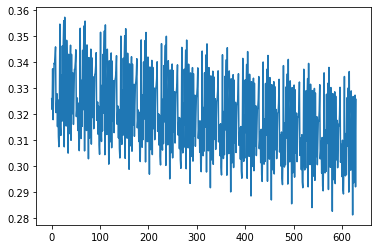

In [43]:
plt.plot(losses)

In [21]:
class DNN(nn.Module):
    def __init__(self,layer_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(52, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
        self.fc4 = nn.Linear(layer_size, layer_size)
        self.fc5 = nn.Linear(layer_size, layer_size)
        self.fc6 = nn.Linear(layer_size, layer_size)
        self.fc7 = nn.Linear(layer_size,1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
#         x = F.dropout(x,self.drop1)
#         x = self.fc2(x)
#         x = torch.tanh(x)
#         x = F.dropout(x,self.drop2)
#         x = self.fc3(x)
#         x = torch.tanh(x)
#         x = F.dropout(x,self.drop3)
#         x = self.fc4(x)
#         x = torch.tanh(x)
#         x = F.dropout(x,self.drop3)
#         x = self.fc5(x)
#         x = torch.tanh(x)
#         x = F.dropout(x,self.drop3)
        x = self.fc7(x)
        output =  x = torch.relu(x)
        
        return output

In [22]:
def train_dnn(layer_size,alpha,batch_size):    
    dnn = DNN(layer_size)
    epochs = 1
    optimizer = torch.optim.SGD(net.parameters(), lr=alpha)
    losses = []
    input_t =[]
    for epoch in range(epochs):
        batch = []
        cnn_input = []
        results = []
        ys = []
        dnn.train()
        react = train["reactivity"].values
        for x in tqdm(range(len(train))):
            adj = create_adj(x)
            for y in range(train.iloc[x]["seq_scored"]):
    #             start = perf_counter()
                one_hot = get_one_hot(x,y,adj)

                for s in (one_hot[0]):
    #                 print(s)
                    input_t.extend(s)
                for l in (one_hot[1]):
    #                 print(l)
                    input_t.extend(l)
    #             end = perf_counter()
    #             print(end-start)
    #             print(input_t)
    #             break
    #             start=perf_counter()
                optimizer.zero_grad()
                batch.append(input_t)
                input_t = []
                ground = [react[x][y]]
                ys.append(ground)
    #             end = perf_counter()
    #             print(end-start)
    #             ys = np.asarray(ys).reshape((1,49))
                if(len(batch)%batch_size==batch_size-1):
                    result = dnn(torch.Tensor(batch).to(device))
                    loss = criterion(result, torch.Tensor(ys).to(device))
                    loss.backward()
                    optimizer.step()
                    losses.append(loss.item())
                    batch = []
                    ys = []
    return (sum(losses)/len(losses))

In [23]:
def objective(trial):
    layer_size = trial.suggest_int('layer_size', 10, 50)
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-3)
    batch_size = trial.suggest_int('batch_size', 500, 2000)
    results = train_dnn(layer_size,alpha,batch_size)
    return results

In [24]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2020-10-01 20:26:45,914] A new study created in memory with name: no-name-141c41ad-d90e-4a4d-95eb-caa31c83ff56
100%|██████████████████████████████████████████████████████████████████████████████| 2097/2097 [02:09<00:00, 16.25it/s]
[I 2020-10-01 20:28:55,253] Trial 0 finished with value: 0.5725367973590719 and parameters: {'layer_size': 41, 'alpha': 0.0007715982036913446, 'batch_size': 1628}. Best is trial 0 with value: 0.5725367973590719.
 16%|████████████▌                                                                  | 335/2097 [00:22<01:58, 14.88it/s]


KeyboardInterrupt: 

In [ ]:
print(sum(losses)/len(losses))
plt.plot(losses)